#### Eduardo Badillo Á A01020716
### Import Libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import time

## Import and analyze data

In [2]:
df = pd.read_csv("Averaged_BearingTest_Dataset.csv")
print("matrix shape",df.shape)
print(df.tail())

matrix shape (982, 2)
           datetime  Bearing1
977  2/19/2004 5:42  0.453335
978  2/19/2004 5:52  0.337583
979  2/19/2004 6:02  0.351111
980  2/19/2004 6:12  0.001857
981  2/19/2004 6:22  0.001168


In [3]:
from datetime import datetime

df['datetime'] = [datetime.strptime(dt, "%m/%d/%Y %H:%M") for dt in df['datetime']]

In [4]:
df.dtypes

datetime    datetime64[ns]
Bearing1           float64
dtype: object

In [5]:
df['Bearing1'].describe()

count    982.000000
mean       0.080951
std        0.040200
min        0.001168
25%        0.060773
50%        0.062021
75%        0.083277
max        0.453335
Name: Bearing1, dtype: float64

#### duration of monitoring

In [6]:
dur_recording = max(df['datetime']) - min(df['datetime'])
print("this monitor duration is exactly: ",dur_recording)

this monitor duration is exactly:  6 days 19:30:00


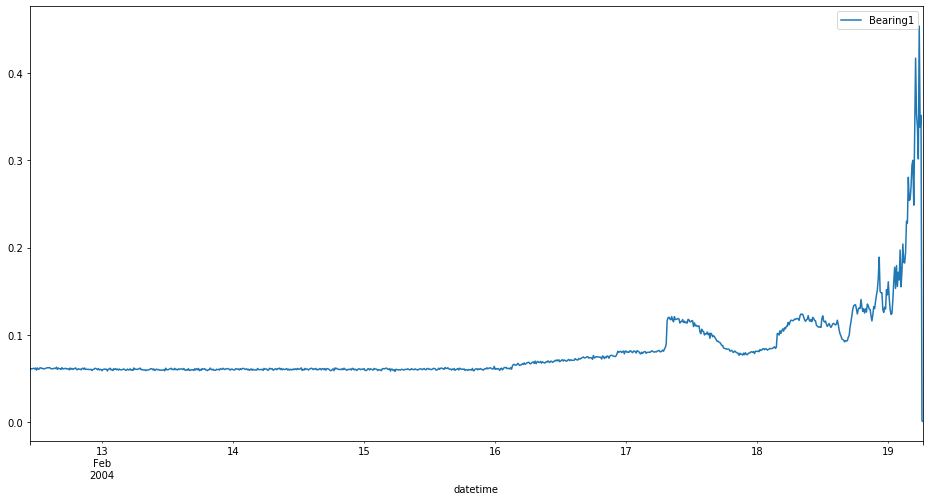

In [7]:
df.plot(x='datetime', y='Bearing1', kind="line", figsize=(16,8))
plt.show()

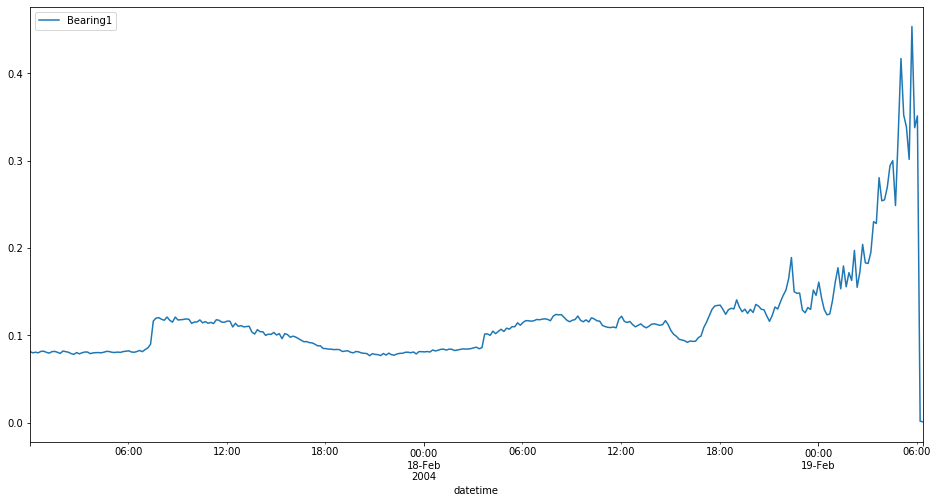

In [17]:
## zoom-in in anomalies
df2 = df.copy()
df2.set_index('datetime', inplace=True)
df2['2004-02-17':'2004-02-19'].plot(kind="line", figsize=(16,8))
plt.show()

We can observe that anomalies start around 7:00 am the 17 of February, 2004

## LSTM RNN

#### Data transformation

In [18]:
# obtain timestamp from datetime, set as index
df2['ts'] = df2.index.values.astype(np.int64) // 10 ** 9 
df2.set_index('ts', inplace=True)

# Split dataset into train and set with given percentages
dataset = df2.values
train_len = round(0.8*len(dataset))
dataset_len = len(dataset)
print("Length of training set:", train_len)

train, test = dataset[0:train_len, :], dataset[train_len:dataset_len, :]

Length of training set: 786


This model doesn't require an (X,y) interaction, because it uses __y(t-delta)__ to predict __y(t)__ <br> 
Where delta is the lookback integer that represents the time steps we will take back.
<br><br>
That is why we add __y+lookback__ steps as our y_train

In [19]:
# Lookback is set as 1 by default
def prepare(ds, lookback=1):
    x, y = [], []
    
    for i in range(len(ds) - lookback-1):
        temp = ds[i: (i+lookback), 0] # 
        x.append(temp)
        y.append(ds[i+lookback, 0]) # 
        
    return np.array(x), np.array(y)

# Pass in train and test sets
x_train, y_train = prepare(train)
x_test, y_test = prepare(test)

# Reshape into format (samples, timesteps, features)
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

#### Create and compile LSTM model

In [20]:
from keras.layers import Dense, LSTM
from keras.models import Sequential 
look_back = 1
model = Sequential()

# input shape: (look_back steps, number of features)
model.add(LSTM(units=4, input_shape=(look_back, 1)))

#model.add(LSTM(units=32, return_sequences=False, dropout= 0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Using TensorFlow backend.
C:\Users\Eduardo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Eduardo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Eduardo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Eduardo\anaconda3\lib\site-packages\tensorflow\python\framework\d

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


#### Train Model

We will test how our model's learning ability changes as we vary validation splits

In [23]:
# Iterate through set of validation splits, train the model and get its history callback
val_splits = [0.1,0.2, 0.25, 0.35]
arr_callbacks = []

for v in val_splits:
    arr_callbacks.append(model.fit(X_train, y_train, epochs=20, verbose=0, batch_size=1, validation_split=v))

Train on 705 samples, validate on 79 samples
Epoch 1/20
705/705 [==============================] - 1s 1ms/step - loss: 4.0433e-06 - val_loss: 1.2894e-05
Epoch 2/20
705/705 [==============================] - 1s 1ms/step - loss: 4.3035e-06 - val_loss: 1.1893e-05
Epoch 3/20
705/705 [==============================] - 1s 1ms/step - loss: 3.6825e-06 - val_loss: 6.5992e-06
Epoch 4/20
705/705 [==============================] - 1s 1ms/step - loss: 3.5512e-06 - val_loss: 2.0465e-05
Epoch 5/20
705/705 [==============================] - 1s 1ms/step - loss: 4.0904e-06 - val_loss: 5.8543e-06
Epoch 6/20
705/705 [==============================] - 1s 1ms/step - loss: 4.0022e-06 - val_loss: 7.6261e-06
Epoch 7/20
705/705 [==============================] - 1s 1ms/step - loss: 3.6745e-06 - val_loss: 7.7799e-06
Epoch 8/20
705/705 [==============================] - 1s 1ms/step - loss: 3.9457e-06 - val_loss: 7.7755e-06
Epoch 9/20
705/705 [==============================] - 1s 1ms/step - loss: 3.7287e-06 - val_

Epoch 15/20
509/509 [==============================] - 1s 2ms/step - loss: 9.5720e-07 - val_loss: 1.9297e-04
Epoch 16/20
509/509 [==============================] - 1s 1ms/step - loss: 1.1131e-06 - val_loss: 2.1795e-04
Epoch 17/20
509/509 [==============================] - 1s 1ms/step - loss: 1.1197e-06 - val_loss: 1.9967e-04
Epoch 18/20
509/509 [==============================] - 1s 1ms/step - loss: 1.1057e-06 - val_loss: 2.2208e-04
Epoch 19/20
509/509 [==============================] - 1s 2ms/step - loss: 1.0781e-06 - val_loss: 2.2150e-04
Epoch 20/20
509/509 [==============================] - 1s 1ms/step - loss: 1.0017e-06 - val_loss: 2.8046e-04


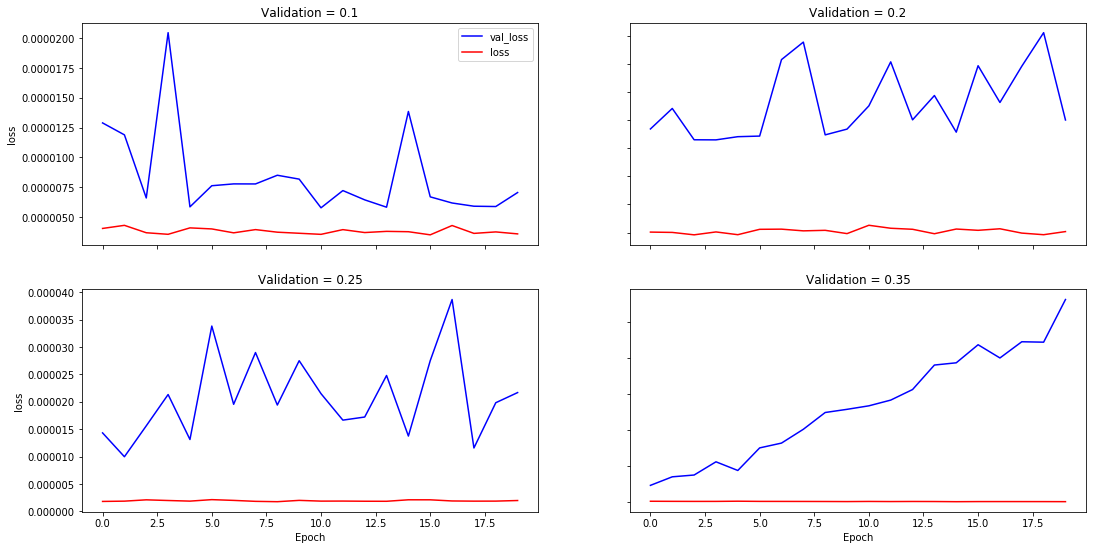

In [35]:
fig, axs = plt.subplots(2,2, figsize=(18,9))

axs[0,0].plot(arr_callbacks[0].history['val_loss'], color='b', label='val_loss')
axs[0,0].plot(arr_callbacks[0].history['loss'], color='r', label='loss')
axs[0,0].set_title('Validation = 0.1')

axs[0,1].plot(arr_callbacks[1].history['val_loss'], color='b', label='val_loss')
axs[0,1].plot(arr_callbacks[1].history['loss'], color='r', label='loss')
axs[0,1].set_title('Validation = 0.2')

axs[1,0].plot(arr_callbacks[2].history['val_loss'], color='b', label='val_loss')
axs[1,0].plot(arr_callbacks[2].history['loss'], color='r', label='loss')
axs[1,0].set_title('Validation = 0.25')

axs[1,1].plot(arr_callbacks[3].history['val_loss'], color='b', label='val_loss')
axs[1,1].plot(arr_callbacks[3].history['loss'], color='r', label='loss')
axs[1,1].set_title('Validation = 0.35')

axs[0,0].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='loss')

for ax in axs.flat:
    ax.label_outer()

plt.show()

Observation: We can see that as validation split increases, the validation loss MSE increases too. <br>
With smaller proportions of the validation data, val_loss and loss tend to converge as more epochs go by <br>
With larger proportions of the validation data, val loss and loss tend to diverge as we see with validation=0.35 <br>
This is largely intuitive, because we have less data for the model to train with and hence its ability to generalize decreases. <br> So it will be in our benefit to use the model with the least validation split.

#### Sequential Experiments

Now we will vary layers and node configuration in the RNN to find an optimal combination

In [60]:
# auxiliary function to return the number of neurons in an ANN
def get_total_number_of_neurons(model, include_output_layer):
    num_layers = len(model.layers)
    total_num_of_neurons = 0
    for layer_index in range(num_layers):
        layer = model.layers[layer_index]
        # since we multiply layer output dimensions, initial value is set to 1.
        num_neurons_in_layer = 1
        for i in range(1, len(layer.output.shape)):
            try:
                # when it is a valid layer to count neurons, an output dimension of the layer can be convertible to int.
                num_neurons_in_layer *= int(layer.output.shape[i])
            except Exception:
                # if the output dimension of layer cannot be convertible to int,
                # just pass that layer since it is not a valid layer to count neurons
                pass
        # if num_neurons_in_layer is not still 1, it means we have a valid layer to count neurons
        if not num_neurons_in_layer == 1:
            # when it is an output layer
            if layer_index == (num_layers - 1):
                if include_output_layer:
                    total_num_of_neurons += num_neurons_in_layer
            else:  # when it is not an output layer
                total_num_of_neurons += num_neurons_in_layer
    return total_num_of_neurons

In [61]:
# Function to create a RNN with a dynamic number of layers and nodes
def create_model(name, nodes=4, layers=1, pr=0):
    
    new_model = Sequential()
    
    new_model.add(LSTM(units=nodes, input_shape=(look_back, 1)))
    if(layers>1):
        for l in range(2, layers+1):
            new_model.add(LSTM(units=nodes))

    new_model.add(Dense(1))

    new_model.compile(optimizer='adam', loss='mean_squared_error')

    if(pr):
        print(new_model.summary())
        
    if(name):
        new_model.name = name
    
    return new_model

In [62]:
model_1 = create_model("m_1", 10, 1, 1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
# Create list of compiled models
model_list = [model_1]
for n_nodes in np.arange(20,110, 10):
    model_name = "m_" + str(n_nodes/10)
    model_list.append(create_model(model_name, n_nodes, 1, 0))

m_dict = {}

# Train each model
for m in model_list:
    
    # time the training 
    t0 = time.time()
    m.fit(X_train, y_train, epochs=20, verbose=0, batch_size=1)
    t1 = time.time()
    
    train_predict = m.predict(X_train)
    test_predict = m.predict(X_test)
    
    # create dictionary for dataframe
    m_dict[m.name] = {"layers": len(m.layers),
                     "nodes": get_total_number_of_neurons(m, False),
                     "train_RMSE": math.sqrt(mean_squared_error(y_train, train_predict)),
                     "test_RMSE": math.sqrt(mean_squared_error(y_test, test_predict)),
                     "train_time": t1-t0}

In [75]:
dict_df = pd.DataFrame(m_dict).T
dict_df

,layers,nodes,train_RMSE,test_RMSE,train_time
m_1,2.0,10.0,0.002159,0.033658,22.343292
m_2.0,2.0,20.0,0.001659,0.033002,23.406288
m_3.0,2.0,30.0,0.001627,0.033821,23.831674
m_4.0,2.0,40.0,0.001810,0.034408,24.494534
m_5.0,2.0,50.0,0.002113,0.033149,24.684576
m_6.0,2.0,60.0,0.001726,0.033131,25.627790
m_7.0,2.0,70.0,0.001656,0.033198,28.904530
m_8.0,2.0,80.0,0.002189,0.032990,29.536674
m_9.0,2.0,90.0,0.001670,0.033454,29.775275
m_10.0,2.0,100.0,0.001657,0.033053,31.214053


Even with a very simple configuration of 10 nodes with a single hidden layer and an output layer, we are seeing a very optimal performance. Adding nodes by increments of 10 slightly increases performance. We will see this graphically in the following plots. 

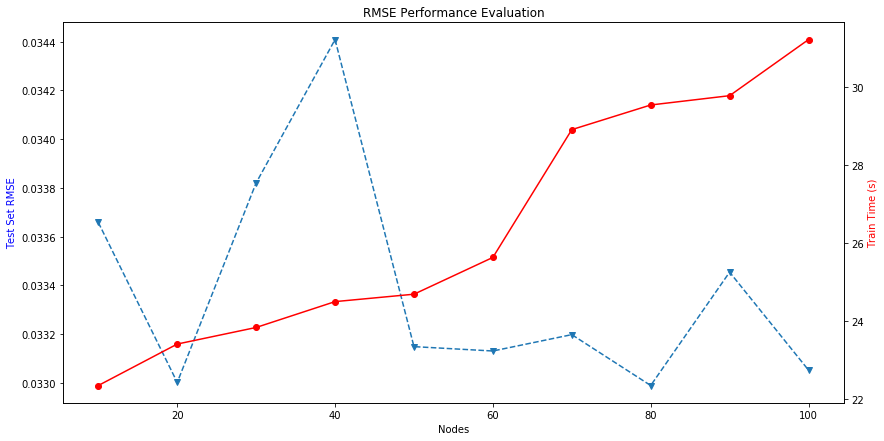

In [87]:
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(dict_df['nodes'], dict_df['test_RMSE'], marker="v", linestyle="--")

ax.set_title("RMSE Performance Evaluation")
ax.set_xlabel("Nodes")
ax.set_ylabel("Test Set RMSE", color='blue')

ax2 = ax.twinx()
ax2.plot(dict_df['nodes'], dict_df['train_time'], marker='o', color='r')
ax2.set_ylabel("Train Time (s)", color='red')


plt.show()

We can see that the obvious best choice is the layer with 20 nodes or the layer with 80 nodes. Both reach about the same RMSE score. But choosing the layer with 20 nodes is the most sensible decision since the training time is less than 24 seconds, whilst the one with 80 neurons is 6 seconds longer. Roughly about 25% more time to train, when working with larger datasets this can be an important factor.

In [21]:
h_callback = model.fit(X_train, y_train, epochs=20, verbose=1, batch_size=1, validation_split=0.15)


Train on 666 samples, validate on 118 samples
Epoch 1/20
666/666 [==============================] - 1s 2ms/step - loss: 1.4424e-04 - val_loss: 0.0014
Epoch 2/20
666/666 [==============================] - 1s 1ms/step - loss: 3.0488e-05 - val_loss: 0.0012
Epoch 3/20
666/666 [==============================] - 1s 1ms/step - loss: 2.8352e-05 - val_loss: 0.0012
Epoch 4/20
666/666 [==============================] - 1s 1ms/step - loss: 2.8934e-05 - val_loss: 0.0011
Epoch 5/20
666/666 [==============================] - 1s 1ms/step - loss: 2.6510e-05 - val_loss: 0.0010
Epoch 6/20
666/666 [==============================] - 1s 1ms/step - loss: 2.4923e-05 - val_loss: 0.0010
Epoch 7/20
666/666 [==============================] - 1s 1ms/step - loss: 2.3200e-05 - val_loss: 9.7679e-04
Epoch 8/20
666/666 [==============================] - 1s 1ms/step - loss: 2.3641e-05 - val_loss: 8.8281e-04
Epoch 9/20
666/666 [==============================] - 1s 1ms/step - loss: 1.9664e-05 - val_loss: 5.9352e-04
Epoch

#### Evaluate performance with validation splits

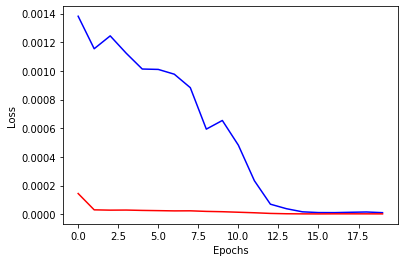

In [22]:
plt.plot(h_callback.history['val_loss'], 'b', h_callback.history['loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Test model with test set

In [104]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [105]:
trainPlot = np.empty_like(dataset)
trainPlot[:,:] = np.nan
trainPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPlot = np.empty_like(dataset)
testPlot[:,:] = np.nan
testPlot[len(train_predict) + (look_back * 2) + 1 : len(dataset) - 1, :] = test_predict

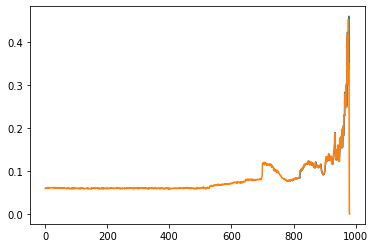

In [107]:
plt.plot(testPlot)
#plt.plot(trainPlot)
plt.plot(dataset)
#plt.ylim([0.060, 0.061])
plt.show()

In [112]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(y_train, train_predict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, test_predict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 0.03 RMSE


In [30]:
# Shift sets with given lookback
# Return x and y, shifted
def prepare(ds, lookback=1):
    x, y = [], []
    
    for i in range(len(ds) - lookback-1):
        temp = ds[i: (i+lookback), 0] # ds[:,0] = ts
        x.append(temp)
        y.append(ds[i+lookback, 1]) # ds[:,1] = Bearing1
        
    return np.array(x), np.array(y)

# Pass in train and test sets
x_train, y_train = prepare(train)
x_test, y_test = prepare(test)

# Reshape into format (samples, timesteps, features)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [63]:
from sklearn.model_selection import train_test_split



#X_train, y_train = np.array(df['datetime']), np.array(df['Bearing1'])
X_train, X_test, y_train, y_test = train_test_split(df['datetime'], df['Bearing1'], test_size=0.2, random_state=21)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Put in appropriate input shape
X_train = X_train.reshape((1, len(X_train), 1))
y_train = y_train.reshape((1, len(y_train), 1))
X_test = X_test.reshape((1, len(X_test), 1))
y_test = y_test.reshape((1, len(y_test), 1))
print(X_train.shape)
# samples, time steps, features

(1, 785, 1)


In [78]:
X_train, X_test, y_train, y_test = train_test_split(df['datetime'], df['Bearing1'], test_size=0.2, random_state=21)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape data to format for LSTM
X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_train.shape

IndexError: tuple index out of range

In [146]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [171]:
def prepare_data(data, train_start, train_end, test_start, test_end,sequence_length):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")
    temp = []
    for index in range(train_start, train_end - sequence_length):
        temp.append(data[index: index + sequence_length])
    temp = np.array(temp)
    #temp, temp_mean = normalize(temp)

    print("Training data shape  : ", temp.shape)

    train = temp[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    temp = []
    for index in range(test_start, test_end - sequence_length):
        temp.append(data[index: index + sequence_length])
    temp = np.array(temp)
    #temp, temp_mean = normalize(temp)

    print("Test data shape  : {}".format(temp.shape))

    X_test = temp[:, :-1]
    y_test = temp[:, -1]
    print(y_test)

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))
    
    return X_train, y_train, X_test, y_test



In [172]:
#X_train, y_train, X_test, y_test = prepare_data(df['datetime'], 0, 900, 600, 900, 100)
X_train, y_train, X_test, y_test = prepare_data(df2.values, 0, 900, 600, 900, 100)

Length of Data 982
Creating training data...
Training data shape  :  (800, 100, 2)
Creating test data...
Test data shape  : (200, 100, 2)
[[9.00038580e-02 1.07700252e+09]
 [1.16488940e-01 1.07700312e+09]
 [1.19798232e-01 1.07700372e+09]
 [1.20306851e-01 1.07700432e+09]
 [1.18443918e-01 1.07700492e+09]
 [1.17357049e-01 1.07700552e+09]
 [1.21051760e-01 1.07700612e+09]
 [1.17350505e-01 1.07700672e+09]
 [1.15163924e-01 1.07700732e+09]
 [1.21010840e-01 1.07700792e+09]
 [1.17639240e-01 1.07700852e+09]
 [1.17974852e-01 1.07700912e+09]
 [1.18264759e-01 1.07700972e+09]
 [1.18874701e-01 1.07701032e+09]
 [1.18471556e-01 1.07701092e+09]
 [1.13744177e-01 1.07701152e+09]
 [1.15343620e-01 1.07701212e+09]
 [1.15384784e-01 1.07701272e+09]
 [1.17729284e-01 1.07701332e+09]
 [1.14375946e-01 1.07701392e+09]
 [1.15795156e-01 1.07701452e+09]
 [1.13907417e-01 1.07701512e+09]
 [1.14880902e-01 1.07701572e+09]
 [1.13596221e-01 1.07701632e+09]
 [1.17948337e-01 1.07701692e+09]
 [1.17312076e-01 1.07701752e+09]
 [1.

ValueError: cannot reshape array of size 158400 into shape (800,99,1)

In [166]:
X_train

array([[[-0.99999998,  0.9998618 ],
        [-0.99999998,  0.99986292],
        [-0.99999998,  0.99986403],
        ...,
        [-0.99999998,  0.99996878],
        [-0.99999998,  0.9999699 ],
        [-0.99999998,  0.99997101]],

       [[-0.99999998,  1.00026186],
        [-0.99999998,  1.00026297],
        [-0.99999998,  1.00026409],
        ...,
        [-0.99999998,  1.00036884],
        [-0.99999998,  1.00036995],
        [-0.99999998,  1.00037106]],

       [[-0.99999998,  0.99954532],
        [-0.99999998,  0.99954644],
        [-0.99999998,  0.99954755],
        ...,
        [-0.99999998,  0.9996523 ],
        [-0.99999998,  0.99965342],
        [-0.99999998,  0.99965453]],

       ...,

       [[-0.99999998,  0.99951524],
        [-0.99999998,  0.99951635],
        [-0.99999998,  0.99951747],
        ...,
        [-0.99999998,  0.99962222],
        [-0.99999998,  0.99962333],
        [-0.99999998,  0.99962444]],

       [[-0.99999998,  0.99964673],
        [-0.99999998,  0.99

## LSTM RNN

In [144]:
#from tensorflow.python.keras.layers import Dense, LSTM
#from tensorflow.python.keras.models import Sequential

from keras.layers import Dense, LSTM
from keras.models import Sequential 

model = Sequential()

model.add(LSTM(units=16, return_sequences=True, input_shape=(100-1, 1), dropout= 0.2))

model.add(LSTM(units=32, return_sequences=False, dropout= 0.2))

model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 99, 16)            1152      
_________________________________________________________________
lstm_38 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


In [145]:
from keras.callbacks import EarlyStopping

esm = EarlyStopping(patience=5)

h_callback = model.fit(X_train, y_train, epochs=12, verbose=1, validation_split=0.2)

Train on 705 samples, validate on 177 samples
Epoch 1/12
705/705 [==============================] - 3s 4ms/step - loss: 1159732701302411771274553629345841152.0000 - val_loss: 1159710902272064305346299390184128512.0000
Epoch 2/12
705/705 [==============================] - 1s 2ms/step - loss: 1159732711416645111040907525708840960.0000 - val_loss: 1159710902272064305346299390184128512.0000
Epoch 3/12
705/705 [==============================] - 1s 2ms/step - loss: 1159732694671969716800518704498475008.0000 - val_loss: 1159710902272064305346299390184128512.0000
Epoch 4/12
705/705 [==============================] - 2s 2ms/step - loss: 1159732687142484711909381441278967808.0000 - val_loss: 1159710902272064305346299390184128512.0000
Epoch 5/12
705/705 [==============================] - 2s 2ms/step - loss: 1159732701302411771274553629345841152.0000 - val_loss: 1159710902272064305346299390184128512.0000
Epoch 6/12
705/705 [==============================] - 1s 2ms/step - loss: 11597326886034296539